In [1]:
from sklearn.ensemble import RandomForestRegressor
import optuna.visualization as vis
import matplotlib.pyplot as plt

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
filepath = '../../split_income_data'

### Loading Datasets

In [3]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [4]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [5]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

### Objective Function

In [50]:
def objective(trial, x_train, y_train, x_val, y_val):

    n_trees = trial.suggest_int("n_estimators", 10, 300)

    max_depth = trial.suggest_int("max_depth", 3, 25)

    min_sample_split = trial.suggest_int("min_samples_split", 2, 10)

    bootstrapping = trial.suggest_categorical("bootstrap", [True, False])
    if bootstrapping == False:
        max_samples = None
    else:
        max_samples = trial.suggest_float("max_samples", 0.01, 1.0)

    rf = RandomForestRegressor(random_state=42, min_samples_split=min_sample_split, bootstrap=bootstrapping, max_samples=max_samples, n_estimators=n_trees, max_depth=max_depth)
    trained_model = rf.fit(x_train, y_train)
    y_pred = trained_model.predict(x_val)
    val_loss = mean_squared_error(y_pred, y_val)

    return val_loss  # Optuna minimizes this

### Model Iteration

#### Code Design

##### Encoding

In [10]:
merged = pd.DataFrame(pd.read_pickle('../../raw_merged_data_v2_withinyears'))
missing_dropped = merged.dropna(axis=1, how='all', ignore_index=True)
rdrop = missing_dropped.dropna(axis=0, how='all', ignore_index=True)
ydrop = missing_dropped.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])

In [11]:
countries = ydrop['setting'].unique()
countries_dict = {}
count = 0
for c in countries:
    countries_dict[c] = count
    count += 1

In [12]:
countries_dict

{'Algeria': 0,
 'Bangladesh': 1,
 'Burkina Faso': 2,
 'Central African Republic': 3,
 'Chad': 4,
 'Congo, Dem. Rep.': 5,
 'Costa Rica': 6,
 "Cote d'Ivoire": 7,
 'Cuba': 8,
 'Dominican Republic': 9,
 'Egypt, Arab Rep.': 10,
 'Ethiopia': 11,
 'Fiji': 12,
 'Gambia, The': 13,
 'Ghana': 14,
 'Guyana': 15,
 'Honduras': 16,
 'India': 17,
 'Indonesia': 18,
 'Iraq': 19,
 'Kenya': 20,
 'Kiribati': 21,
 'Kyrgyz Republic': 22,
 'Lao PDR': 23,
 'Lesotho': 24,
 'Madagascar': 25,
 'Malawi': 26,
 'Mongolia': 27,
 'Montenegro': 28,
 'Nepal': 29,
 'Niger': 30,
 'Nigeria': 31,
 'North Macedonia': 32,
 'Pakistan': 33,
 'Sao Tome and Principe': 34,
 'Serbia': 35,
 'Sierra Leone': 36,
 'Suriname': 37,
 'Togo': 38,
 'Tunisia': 39,
 'Turkmenistan': 40,
 'Uganda': 41,
 'Uzbekistan': 42,
 'Viet Nam': 43,
 'West Bank and Gaza': 44,
 'Afghanistan': 45,
 'Albania': 46,
 'Angola': 47,
 'Argentina': 48,
 'Armenia': 49,
 'Australia': 50,
 'Austria': 51,
 'Azerbaijan': 52,
 'Bahrain': 53,
 'Barbados': 54,
 'Belarus': 

In [13]:
testing_data = train[0][2 * 2].copy()
testing_data['setting'] = testing_data['setting'].map(countries_dict)
testing_data['setting']

0        97
1        51
2        52
3       126
4       101
       ... 
1959    101
1960    121
1961    148
1962     54
1963     92
Name: setting, Length: 1964, dtype: int64

In [14]:
train[0][2 * 2]['setting']

0            Hungary
1            Austria
2         Azerbaijan
3        Netherlands
4             Israel
            ...     
1959          Israel
1960         Moldova
1961    South Africa
1962        Barbados
1963         Grenada
Name: setting, Length: 1964, dtype: object

In [15]:
import pickle 

with open('../../split_income_models/countries_dict.pkl', 'wb') as f:
    pickle.dump(countries_dict, f)

In [16]:
with open('../../split_income_models/countries_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
loaded_dict

{'Algeria': 0,
 'Bangladesh': 1,
 'Burkina Faso': 2,
 'Central African Republic': 3,
 'Chad': 4,
 'Congo, Dem. Rep.': 5,
 'Costa Rica': 6,
 "Cote d'Ivoire": 7,
 'Cuba': 8,
 'Dominican Republic': 9,
 'Egypt, Arab Rep.': 10,
 'Ethiopia': 11,
 'Fiji': 12,
 'Gambia, The': 13,
 'Ghana': 14,
 'Guyana': 15,
 'Honduras': 16,
 'India': 17,
 'Indonesia': 18,
 'Iraq': 19,
 'Kenya': 20,
 'Kiribati': 21,
 'Kyrgyz Republic': 22,
 'Lao PDR': 23,
 'Lesotho': 24,
 'Madagascar': 25,
 'Malawi': 26,
 'Mongolia': 27,
 'Montenegro': 28,
 'Nepal': 29,
 'Niger': 30,
 'Nigeria': 31,
 'North Macedonia': 32,
 'Pakistan': 33,
 'Sao Tome and Principe': 34,
 'Serbia': 35,
 'Sierra Leone': 36,
 'Suriname': 37,
 'Togo': 38,
 'Tunisia': 39,
 'Turkmenistan': 40,
 'Uganda': 41,
 'Uzbekistan': 42,
 'Viet Nam': 43,
 'West Bank and Gaza': 44,
 'Afghanistan': 45,
 'Albania': 46,
 'Angola': 47,
 'Argentina': 48,
 'Armenia': 49,
 'Australia': 50,
 'Austria': 51,
 'Azerbaijan': 52,
 'Bahrain': 53,
 'Barbados': 54,
 'Belarus': 

##### Code

In [53]:
train[0][2 * 2 + 1].column = 'Maternal mortality ratio (national estimate per 100,000 live births)'
validation[0][1].column = 'Maternal mortality ratio (national estimate per 100,000 live births)'
test_data_y.column = 'Maternal mortality ratio (national estimate per 100,000 live births)'

testing_x = test_data_x.copy()
testing_x['setting'] = testing_x['setting'].map(countries_dict)

val_input_data = validation[0][0].copy()
val_input_data['setting'] = val_input_data['setting'].map(countries_dict)

train_input_data = train[0][2 * 2].copy()
train_input_data['setting'] = train_input_data['setting'].map(countries_dict)


#Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_input_data, train[0][2 * 2 + 1], val_input_data, validation[0][1]), n_trials=2)
best_model = RandomForestRegressor(**study.best_params)
best_model.fit(train_input_data, train[0][2 * 2 + 1])

best_pred = best_model.predict(val_input_data)
best_val_loss = mean_squared_error(best_pred, validation[0][1])

best_pred_test = best_model.predict(testing_x)
best_test_loss = mean_squared_error(best_pred_test, test_data_y)

[I 2025-07-23 20:47:54,294] A new study created in memory with name: no-name-a1548f75-68c7-4758-a0a8-1daa8674777a
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-07-23 20:47:55,069] Trial 0 finished with value: 10042.595234324705 and parameters: {'n_estimators': 285, 'max_depth': 25, 'min_samples_split': 6, 'bootstrap': True, 'max_samples': 0.022873841950194096}. Best is trial 0 with value: 10042.595234324705.
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-07-23 20:47:59,279] Trial 1 finished with value: 6918.776480052393 and parameter

#### Code Implementation

In [55]:
output_dir = '../../split_income_models/random_forest'

In [ ]:
for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].map(countries_dict)

    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_label = validation[fold][1] 

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx != 2:
            continue
        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].map(countries_dict)
        train_label = train[fold][thresh_idx * 2 + 1]

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_input_data, val_label), n_trials=300)
        best_model = RandomForestRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'xgboost',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-07-23 20:53:59,485] A new study created in memory with name: no-name-29092252-1aa3-49b6-9458-cb407b84e70d
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-07-23 20:54:08,667] Trial 0 finished with value: 10261.590061994762 and parameters: {'n_estimators': 40, 'max_depth': 15, 'min_samples_split': 5, 'bootstrap': False}. Best is trial 0 with value: 10261.590061994762.
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-07-23 20:54:24,673] Trial 1 finished with value: 8255.212984715172 and parameters: {'n_estimators': 126, 'max_depth':

KeyboardInterrupt: 

### Loading Models

In [6]:
output_dir = '../../split_income_models/random_forest'

#### Test values for all models

In [7]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)
test_stats = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

test_stats

MAPE  MAE  MSE RMSE   R2
Missing Data Threshold Fold                         
Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
None                   1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN

In [ ]:
best_parameters = []
best_values = []

In [17]:
testing_x = test_data_x.copy()
testing_x['setting'] = testing_x['setting'].map(countries_dict)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        if thresh == 0 or thresh == 1:
            continue
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")
        best_parameters.append(best_params)
        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].map(countries_dict)

        loaded_model = RandomForestRegressor(**best_params)
        train_load = loaded_model.fit(train_input_data, train[fold][thresh * 2 + 1])
        prediction = train_load.predict(testing_x)
        mse = mean_squared_error(prediction, test_data_y)
        mae = mean_absolute_error(prediction, test_data_y)
        rmse = np.sqrt(mse)
        r2 = r2_score(prediction, test_data_y)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        
        mape = mape/num_predictions

        test_stats.loc[(thresh_name, fold_num), 'MSE'] = mse
        test_stats.loc[(thresh_name, fold_num), 'MAE'] = mae
        test_stats.loc[(thresh_name, fold_num), 'RMSE'] = rmse
        test_stats.loc[(thresh_name, fold_num), 'R2'] = r2
        test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
        

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_74752/1145670722.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_74752/1145670722.py:40: Futu

#### Best Parameters

In [ ]:
best_parameters[0]

{'n_estimators': 66,
 'max_depth': 25,
 'min_samples_split': 2,
 'bootstrap': True,
 'max_samples': 0.11519821252037958}

In [74]:
best_parameters[1]

{'n_estimators': 66,
 'max_depth': 19,
 'min_samples_split': 5,
 'bootstrap': True,
 'max_samples': 0.14947549764383067}

In [75]:
best_parameters[2]

{'n_estimators': 232,
 'max_depth': 8,
 'min_samples_split': 6,
 'bootstrap': True,
 'max_samples': 0.8750712958895288}

In [76]:
best_parameters[3]

{'n_estimators': 153,
 'max_depth': 6,
 'min_samples_split': 3,
 'bootstrap': True,
 'max_samples': 0.6659147732815236}

In [77]:
best_parameters[4]

{'n_estimators': 15,
 'max_depth': 18,
 'min_samples_split': 2,
 'bootstrap': True,
 'max_samples': 0.48067980970732865}

#### Visualisations

In [18]:
test_stats

MAPE        MAE           MSE       RMSE  \
Missing Data Threshold Fold                                                 
Threshold 85%          1          NaN        NaN           NaN        NaN   
                       2          NaN        NaN           NaN        NaN   
                       3          NaN        NaN           NaN        NaN   
                       4          NaN        NaN           NaN        NaN   
                       5          NaN        NaN           NaN        NaN   
Threshold 95%          1          NaN        NaN           NaN        NaN   
                       2          NaN        NaN           NaN        NaN   
                       3          NaN        NaN           NaN        NaN   
                       4          NaN        NaN           NaN        NaN   
                       5          NaN        NaN           NaN        NaN   
None                   1      0.41859   37.36595   9717.056821  98.575133   
                       2     0.422103  35.679328   8148.885878   90.27118   
                       3     0.420578  38.090954   8480.416246  92.089176   
                       4     0.430265  37.261287   8440.814444  91.873905   
                       5     0.425715  40.851221  11458.000542  107.04205   

                                   R2  
Missing Data Threshold Fold            
Threshold 85%          1          NaN  
                       2          NaN  
                       3          NaN  
                       4          NaN  
                       5          NaN  
Threshold 95%          1          NaN  
                       2          NaN  
                       3          NaN  
                       4          NaN  
                       5          NaN  
None                   1     0.390266  
                       2     0.502405  
                       3     0.561723  
                       4     0.605861  
                       5     0.446767

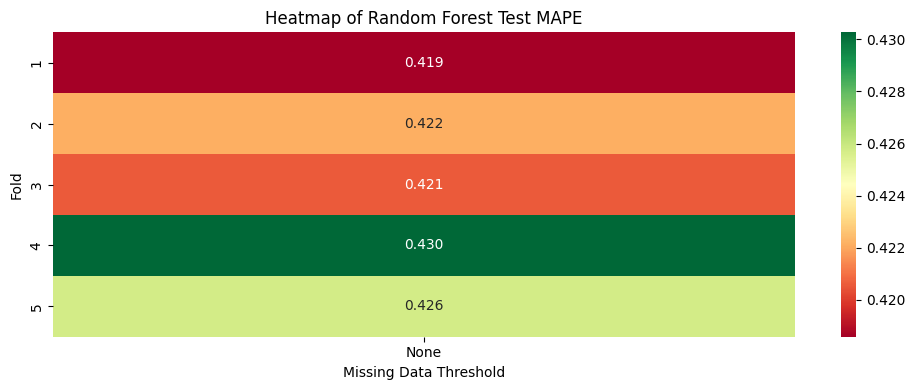

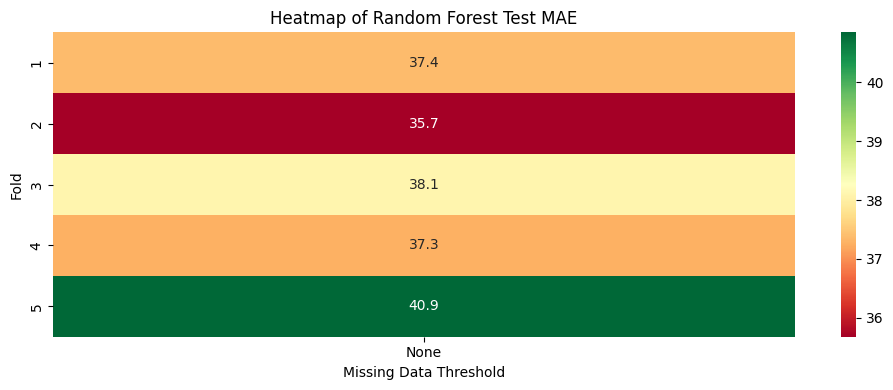

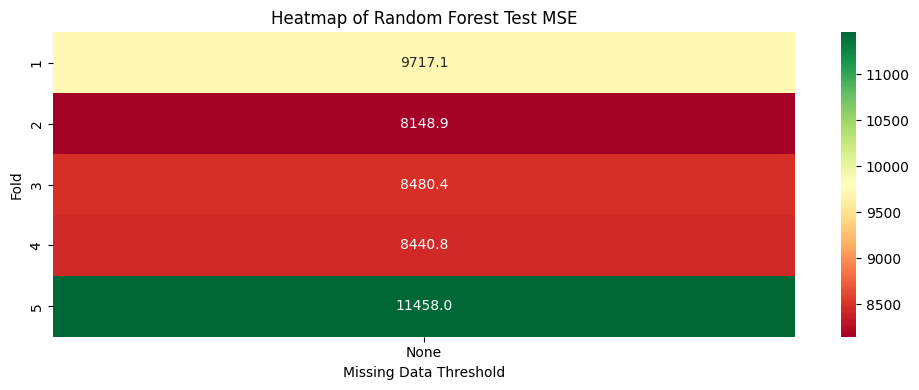

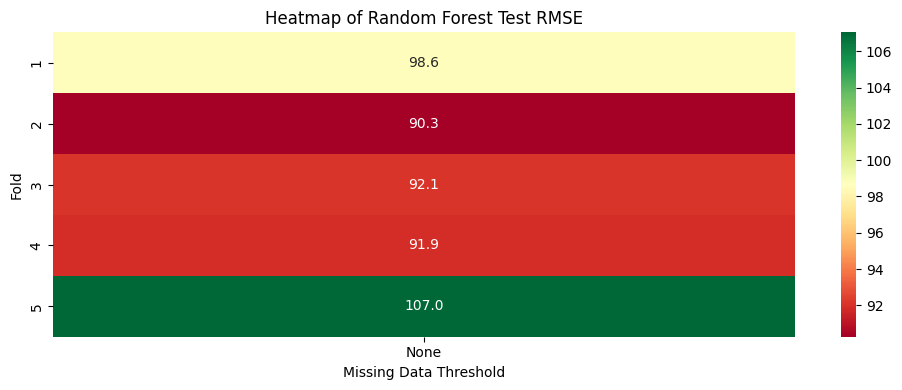

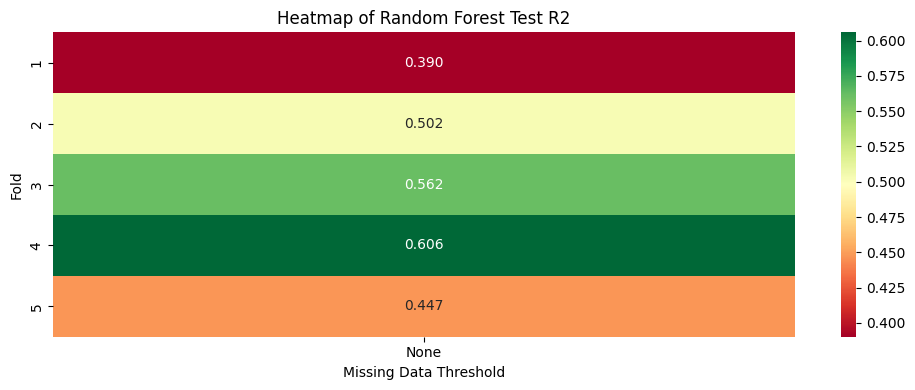

In [20]:
import seaborn as sns

data = test_stats.astype(float)

for metric in data.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data[metric].unstack(level='Missing Data Threshold')['None'])
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn", cbar=True)
    plt.title("Heatmap of Random Forest Test " + metric)
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

### extras